# Optimization Tutorial

Trey V. Wenger (c) March 2025

Here we demonstrate how to optimize the number of cloud components in a `EmissionAbsorptionModel` model.

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.21.1
bayes_spec version: 1.7.5
caribou_hi version: 1.3.1a0+1.g7fcf136.dirty


## Model Definition and Simulated Data

In [2]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-60.0, 60.0, 200)  # km s-1
absorption_axis = np.linspace(-30.0, 30.0, 100)  # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1  # K
rms_absorption = 0.01  # 1 - exp(-tau)

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

In [3]:
from caribou_hi import EmissionAbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = EmissionAbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 10.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_nth_fwhm_1pc=[0.2, 0.1],  # log10(non-thermal FWHM at 1 pc) prior mean and width (km s-1)
    prior_depth_nth_fwhm_power=[0.3, 0.1],  # non-thermal FWHM vs. depth power law index prior mean and width
    prior_fwhm_L=None,  # Assume Gaussian line profile
    prior_baseline_coeffs=None,  # Default baseline priors
    ordered=False,  # do not assume optically-thin
    hyper_depth_linewidth=False,  # do not assume shared size-linewidth relationship
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([20.5, 20.25, 21.0]),
    "log10_depth": np.array([0.5, 1.5, 2.5]),
    "log10_pressure": np.array([3.25, 3.0, 3.75]),
    "velocity": np.array([-4.0, 0.0, 15.5]),
    "log10_n_alpha": -6.5,
    "log10_nth_fwhm_1pc": [0.2, 0.3, 0.4],
    "depth_nth_fwhm_power": [0.2, 0.4, 0.3],
    "filling_factor": [0.3, 0.8, 1.0],
    "absorption_weight": [0.8, 0.9, 1.0],
    "baseline_emission_norm": [0.0],
    "baseline_absorption_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observation
emission = model.model["emission"].eval(sim_params, on_unused_input="ignore")
absorption = model.model["absorption"].eval(sim_params, on_unused_input="ignore")

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

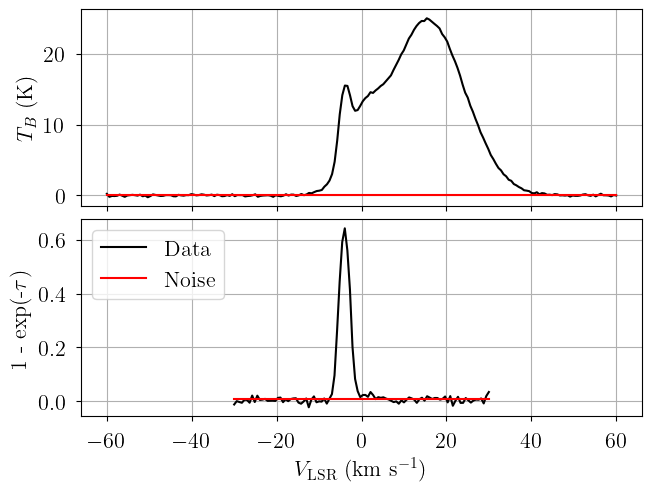

In [5]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[0].plot(data["emission"].spectral, data["emission"].noise, "r-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-", label="Data")
axes[1].plot(data["absorption"].spectral, data["absorption"].noise, "r-", label="Noise")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
axes[1].set_ylabel(data["absorption"].ylabel)
_ = axes[1].legend(loc="upper left")

## `Optimize`

We use the `Optimize` class for optimization.

In [7]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    EmissionAbsorptionModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=baseline_degree,  # polynomial baseline degree
    bg_temp=3.77,  # assumed background brightness temperature (K)
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 10.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_nth_fwhm_1pc=[0.2, 0.1],  # log10(non-thermal FWHM at 1 pc) prior mean and width (km s-1)
    prior_depth_nth_fwhm_power=[0.3, 0.1],  # non-thermal FWHM vs. depth power law index prior mean and width
    prior_fwhm_L=None,  # Assume Gaussian line profile
    prior_baseline_coeffs=None,  # Default baseline priors
    ordered=False,  # do not assume optically-thin
    hyper_depth_linewidth=False,  # do not assume hyper size-linewidth relationship
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [8]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. This is generally a bad idea, since VI is only an approximation and tends to struggle with complex models. Instead we use `approx=False` to sample every model with MCMC. This is slower but more robust.

We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model. The algorithm will terminate early if successive models have increasing BICs or fail to converge.

In [9]:
fit_kwargs = {
    "rel_tolerance": 0.05,
    "abs_tolerance": 0.05,
    "learning_rate": 0.01,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs, approx=False)

Null hypothesis BIC = 1.338e+06
CHECK {'rel_tolerance': 0.05, 'abs_tolerance': 0.05, 'learning_rate': 0.01}
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5800
Interrupted at 5,799 [5%]: Average Loss = 2.0134e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power, filling_factor, absorption_weight]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 312 seconds.


Adding log-likelihood to trace


Output()

There were 80 divergences in converged chains.
GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 5.861e+04

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 11800
Interrupted at 11,799 [11%]: Average Loss = 91,619
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power, filling_factor, absorption_weight]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 328 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.698e+04

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 11400
Interrupted at 11,399 [11%]: Average Loss = 84,578
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power, filling_factor, absorption_weight]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 358 seconds.


Adding log-likelihood to trace


Output()

There were 125 divergences in converged chains.
GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = -8.552e+02

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 14600
Interrupted at 14,599 [14%]: Average Loss = 66,495
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power, filling_factor, absorption_weight]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 385 seconds.


Adding log-likelihood to trace


Output()

There were 98 divergences in converged chains.
GMM converged to unique solution
2 of 8 chains appear converged.
n_cloud = 4 solution = 0 BIC = -8.147e+02

Stopping criteria met.
Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 11200
Interrupted at 11,199 [11%]: Average Loss = 91,750
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power, filling_factor, absorption_weight]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 420 seconds.


Adding log-likelihood to trace


Output()

There were 105 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Stopping criteria met.
Stopping early.


In [10]:
opt.best_model.n_clouds

3

Sampling: [absorption, emission]


Output()

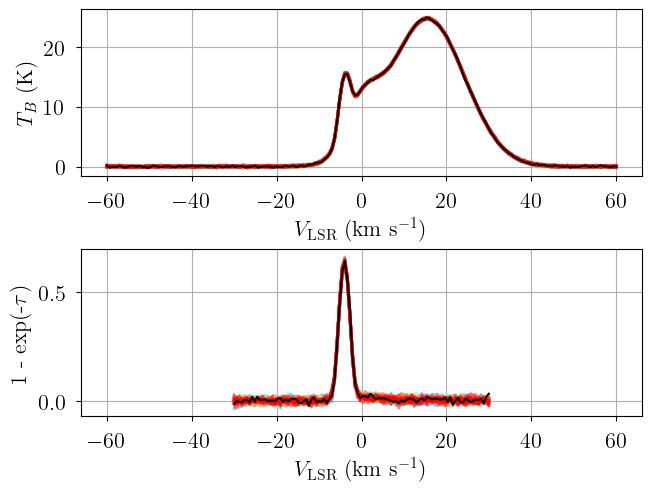

In [11]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(opt.best_model.data, posterior.posterior_predictive)
axes.ravel()[0].sharex(axes.ravel()[1])